In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pygmt
import rf
import obspy
from math import ceil

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize



In [4]:
dataroot = "/g/data/ha3/am3591/analysis2"
network_dir = os.path.join(dataroot, "ALL-analysis")
latest_run = max(
    [
        os.path.join(network_dir, d)
        for d in os.listdir(network_dir)
        if os.path.isdir(os.path.join(network_dir, d))
    ],
    key=os.path.getmtime,
)
latest_run = os.path.join(network_dir, latest_run)
stream = rf.read_rf(os.path.join(latest_run, "rfstream.h5"), format='h5')
stacks = rf.read_rf(os.path.join(latest_run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])


In [8]:
delays_df = pd.read_csv(os.path.join(latest_run, "delays.txt"), names=("Network", "Station", "Longitude", "Latitude", "TPsb"), sep="\s+")
delays_df.set_index("Station", inplace=True)
delays_df.head()

Network  Longitude  Latitude  TPsb
Station                                   
E1D2         4H   141.6929  -32.2077  0.00
E1B1         4H   141.2399  -31.2544  0.02
E1B2         4H   141.6806  -31.2328  0.02
E1A4         4H   142.9297  -30.7477  0.04
E1C2         4H   141.7588  -31.7165  0.04

<Axes: xlabel='TPsb', ylabel='Count'>

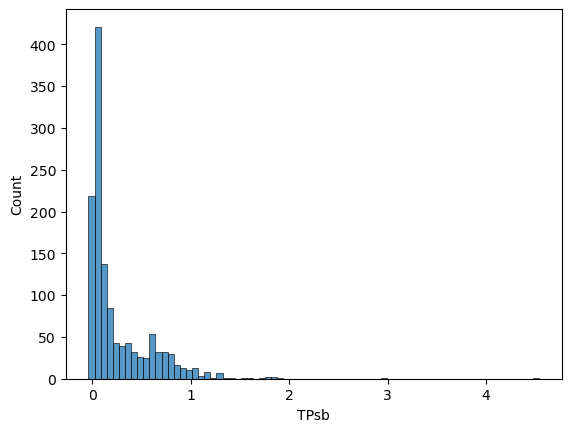

In [9]:
sns.histplot(data=delays_df, x="TPsb")

In [11]:
delays_df[delays_df["TPsb"] > 2]

Network   Longitude   Latitude  TPsb
Station                                     
BO33         OA  131.000400 -24.000000  2.94
BM31         OA  129.993058 -22.995938  4.54

In [12]:
delays_df[delays_df["TPsb"] < 0]

Network  Longitude  Latitude  TPsb
Station                                   
DPH          AU   130.8423  -12.4667 -0.04

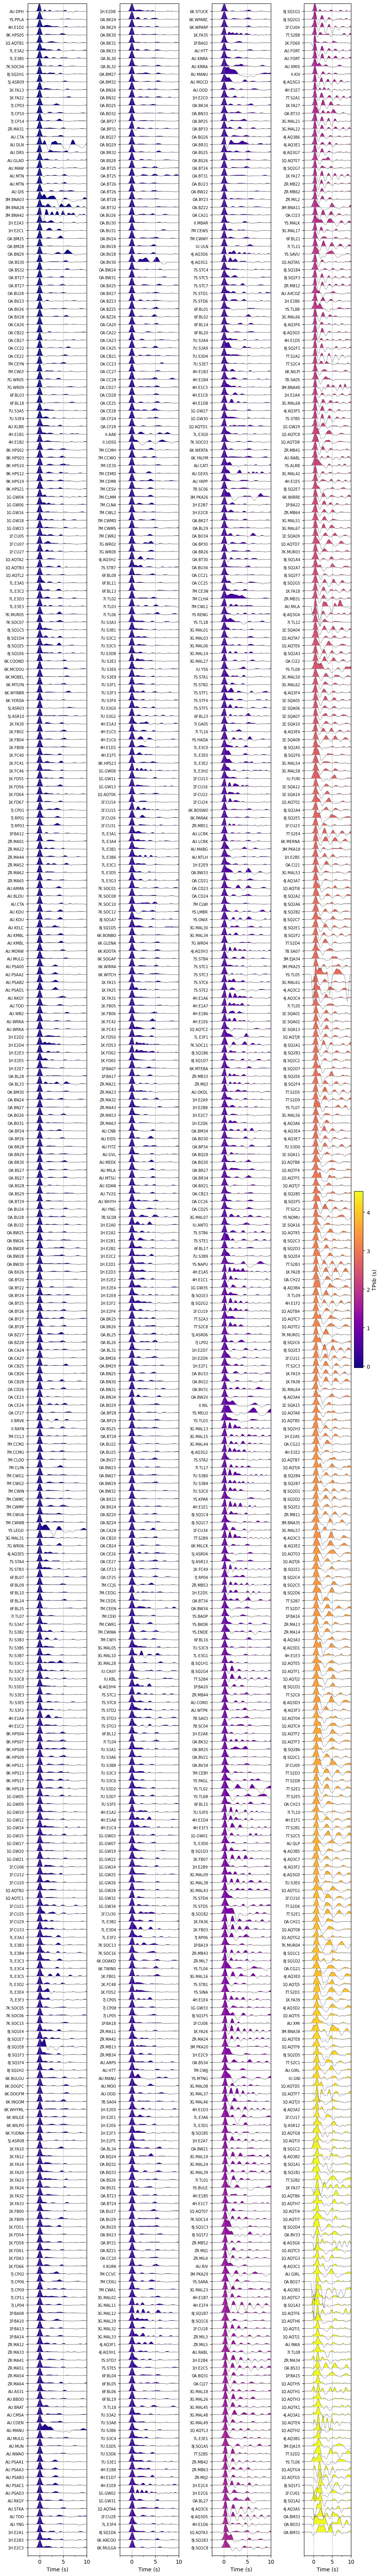

In [28]:
delays = [trace.stats.delay for trace in stacks]
norm = Normalize(vmin=min(delays), vmax=max(delays))
cmap = cm.plasma
nstacks = len(stacks)
ncols = 4
stacks_per_column = ceil(nstacks / ncols)

stack_height = 0.2
column_height = stack_height * stacks_per_column
fig, axs = plt.subplots(1, ncols, figsize=(10, column_height + 2), tight_layout=True)
for j, ax in enumerate(axs):
    i = 0
    column_stations = []
    while i < stacks_per_column:
        try:
            stack = stacks[j * stacks_per_column + i]
        except IndexError:
            # plot nothing so that what is plotted doesn't get stretched along y
            ax.plot(times, data + i, alpha=0)
            i += 1
            continue
        times = stack.times() - stack.stats.onset.second
        data = stack.data
        data /= data.max()
        level = stacks_per_column - 1 - i
        ax.fill_between(times, data + level, level, where=data>=0, fc=cmap(stack.stats.delay))
        ax.plot(times, data + level, "k", lw=0.3)
        column_stations.append(".".join([stack.meta.network, stack.meta.station]))
        i += 1
    while i:
        try:
            ax.set_yticks(np.arange(stacks_per_column - 1, stacks_per_column - 1 - i, -1), column_stations, fontsize="x-small", horizontalalignment="right")
        except ValueError:  # i != len(column_stations) 
            i -= 1
        else:
            break

for ax in axs:
    ax.xaxis.set_minor_locator(MultipleLocator(2.5))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlim([-2.5, 10])
    ax.set_ylim([-1, stacks_per_column])
    ax.grid(True, ls="--")
    ax.set_xlabel("Time (s)")

sm = cm.ScalarMappable(norm, cmap=cmap)
plt.colorbar(sm, label="TPsb (s)", ax=axs[-1])

In [42]:
events = {}
for tr in stream:
    m = tr.meta
    if m.event_id not in events:
        events[m.event_id.split("=")[-1]] = [m.event_longitude, m.event_latitude, m.event_depth, m.event_magnitude, m.distance]
events_df = pd.DataFrame(data=events, index=("Longitude", "Latitude", "Depth", "Magnitude", "Distance")).T
events_df.head()

Longitude  Latitude     Depth  Magnitude   Distance
603824898  -176.5188  -17.1613  370.1334       6.01  35.048825
603823975    96.8488    2.0171   21.5824       5.75  58.351435
603834082   149.1330   44.4691   34.0610       5.90  74.807670
603861057   146.7654   20.7360   22.6527       5.79  50.965071
604007560   109.2225   -8.0446   87.7957       6.03  42.458004

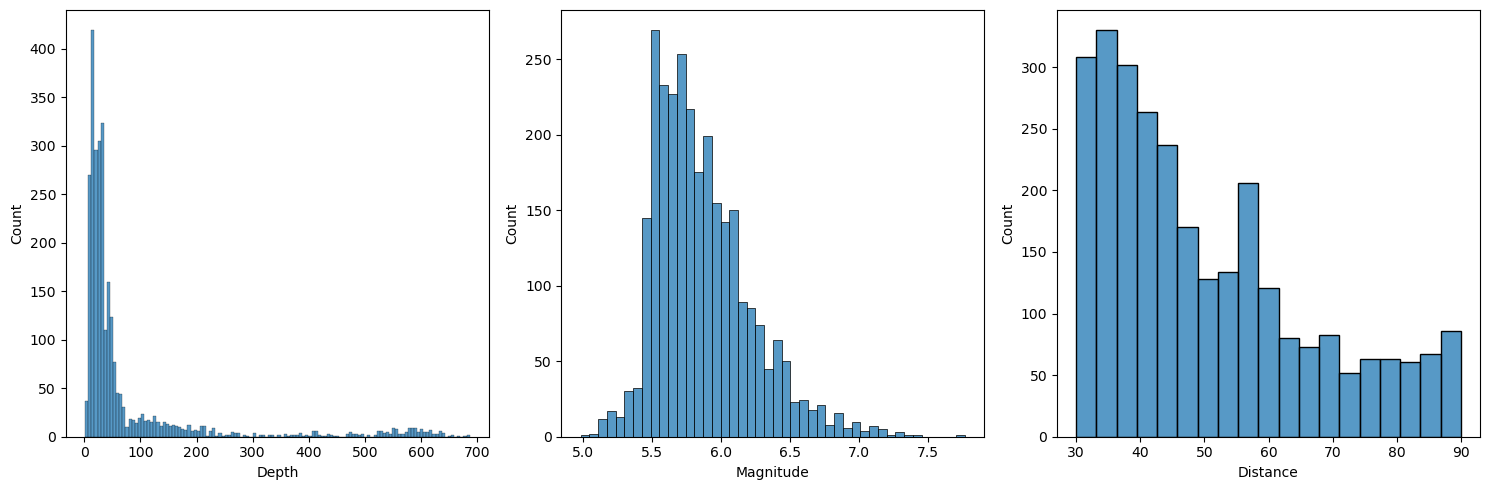

In [45]:
plot_these = ["Depth", "Magnitude", "Distance"]
fig, axs = plt.subplots(1, 3, figsize=(15,5), tight_layout=True)
for ax, d in zip(axs, plot_these):
    sns.histplot(data=events_df, x=d, ax=ax)
    ax.set_xlabel(d)

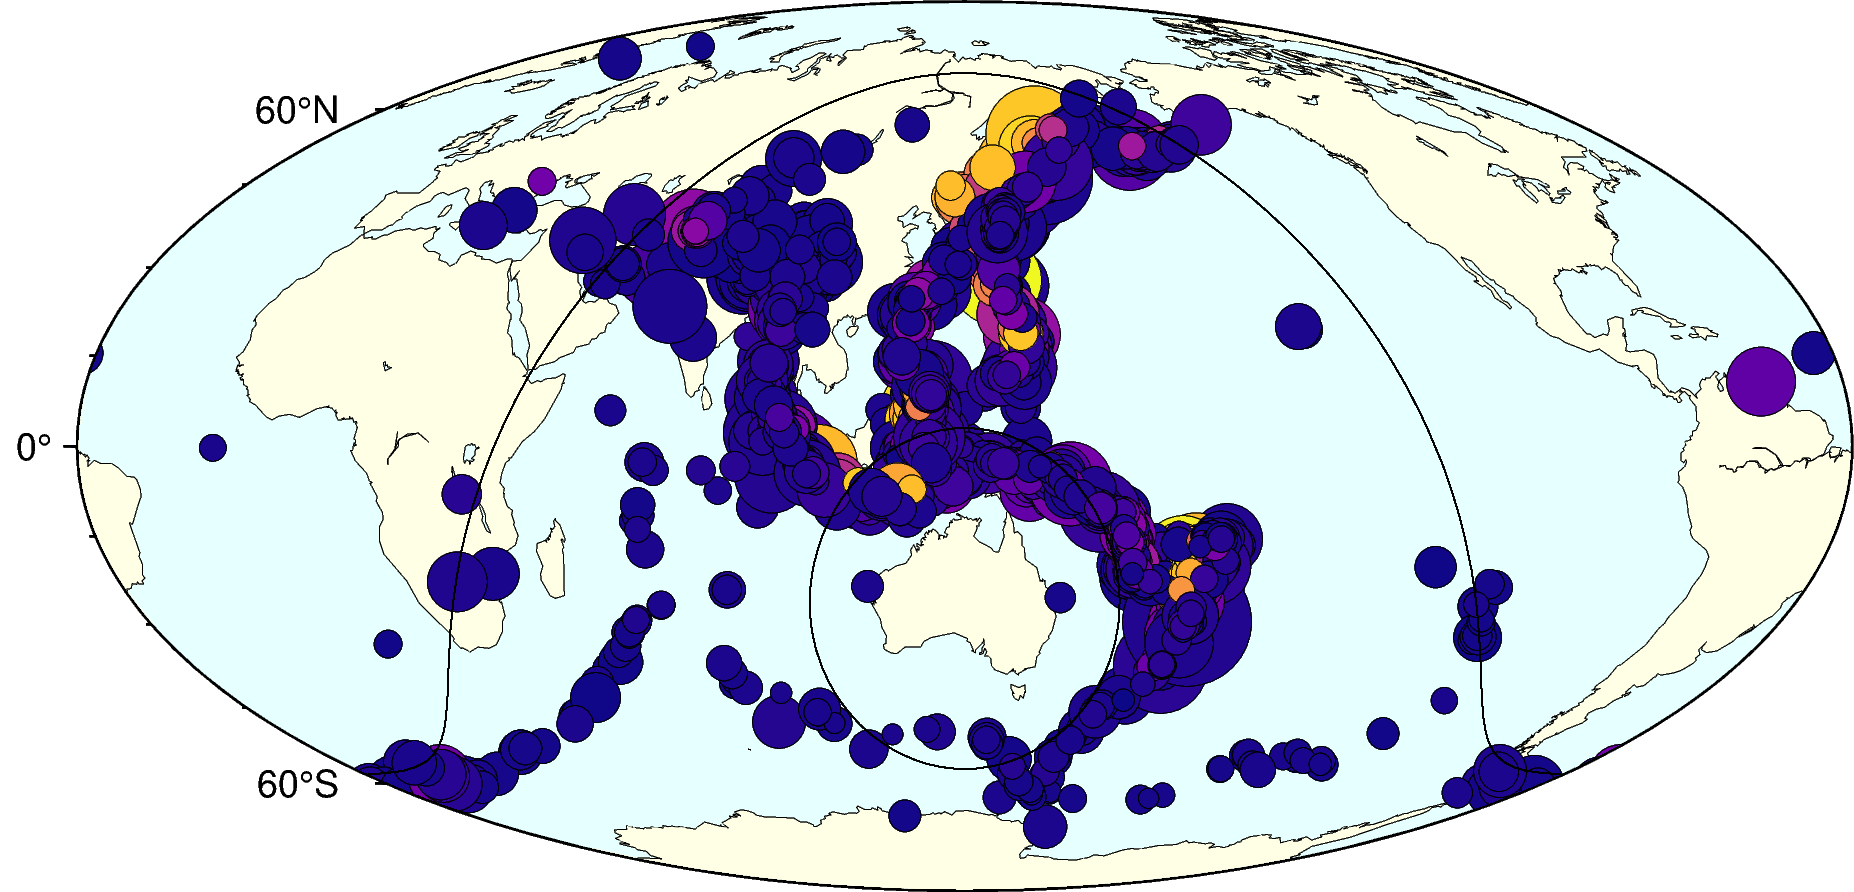

In [70]:
lon = (112 + 155) / 2
lat = (-46 + -8) / 2

region = "d"
projection = f"W{lon}/15c"
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection)
fig.coast(
    region=region,
    projection=projection,
    area_thresh=10000,
    shorelines="0.1,black,solid",
    land="#ffffe6",
    water="#e6ffff",
)
pygmt.makecpt(cmap="plasma", series=[events_df.Depth.min(), events_df.Depth.max()])
fig.plot(
    region=region,
    projection=projection,
    x=events_df.Longitude,
    y=events_df.Latitude,
    size=0.005 * (2**events_df.Magnitude),
    style="cc",
    fill=events_df.Depth,
    cmap=True,
    pen="0.1p,black"
)
fig.plot(
    region=region,
    projection=projection,
    x=[lon] * 2,
    y=[lat] * 2,
    size=[30 *2, 95*2],
    style="E-d",
)

fig.show()
